In [1]:
%matplotlib inline
from IPython.display import HTML,Image,SVG,YouTubeVideo


# Histogram based segmentation

All the pixels in the image are processed the same way.

* common method
* easy and fast
* used when pixel value has a direct interpretation 

e.g. Hounsfield Unit in CT scan
$$HU = 1000\times\frac{\mu - \mu_{water}}{\mu_{water} - \mu_{air}}$$

Imaging: Substance densities in Hounsfield Units (Radiodensity)

    Air: -1000
    Lung: -700
    Soft Tissue: -300 to -100
    Fat: -50
    Water: 0
    CSF: +15
    Blood: +30 to +45
    Muscle: +40
    Calculus: +100 to +400
    Bone: +1000 (up to +3000 for dense bone)

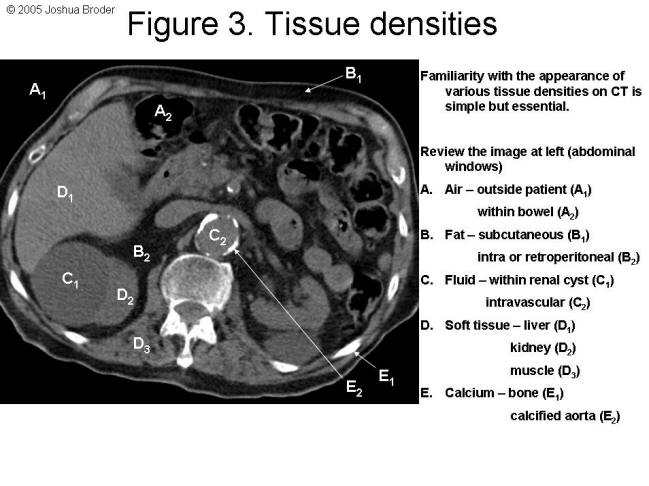

In [2]:
Image('http://crashingpatient.com/wp-content/images/part1/tissuedensities.jpg')

a problem can arise when:
* the illumination is uneven
* in presence of shadows
* when the object of interest has a variable brightness or texture, etc

## Image threshold

definition

$$\begin{align*} 
g(i,j) &= 1 \, \text{if} \, f(i,j)>T \\
\,  &= 0 \, \text{otherwise}
\end{align*}$$

$T$ can be:
* fixed: $T = T0$
* globally adaptive: $T = T(f)$
* locally adaptive: $T = T(f,fc)$

### some examples

In [31]:
from skimage import data
import matplotlib.pyplot as plt
import numpy as np

def norm_hist(ima):
    hist,bins = np.histogram(ima.flatten(),range(256))  # histogram is computed on a 1D distribution --> flatten()
    return 1.*hist/np.sum(hist) # normalized histogram

def display_hist(ima):
    plt.figure(figsize=[10,5])
    if ima.ndim == 2:
        nh = norm_hist(ima)
    else:
        nh_r = norm_hist(ima[:,:,0])
        nh_g = norm_hist(ima[:,:,1])
        nh_b = norm_hist(ima[:,:,2])
    # display the results
    plt.subplot(1,2,1)
    plt.imshow(ima,cmap=plt.cm.gray)
    plt.subplot(1,2,2)
    if ima.ndim == 2:
        plt.plot(nh,label='hist.')
    else:
        plt.plot(nh_r,color='r',label='r')
        plt.plot(nh_g,color='g',label='g')
        plt.plot(nh_b,color='b',label='b')
    plt.legend()
    plt.xlabel('gray level');

(array([43412, 87788,     0,     0,     0,     0,     0,     0,     0]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

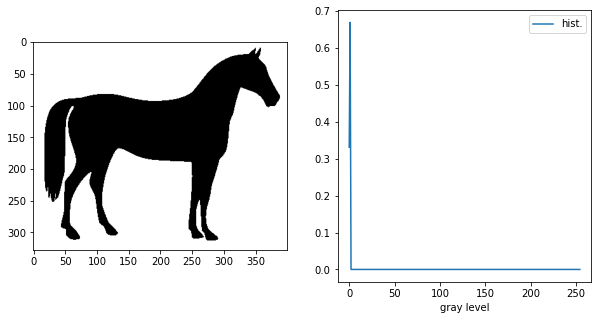

In [32]:
g = data.horse()[:].astype(np.uint8)
display_hist(g)
h = np.histogram(g,range(10))
h

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


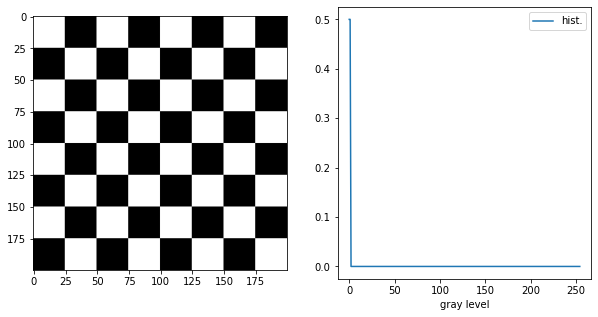

In [5]:
    display_hist(data.checkerboard()>128)


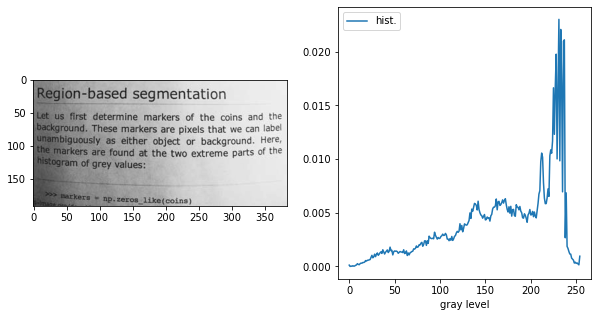

In [6]:
display_hist(data.page())

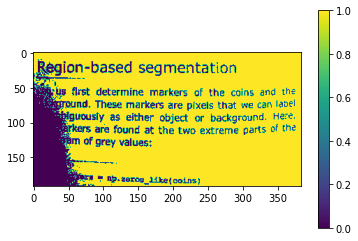

In [38]:
g = data.page()
t = g>120
plt.imshow(t)
plt.colorbar()

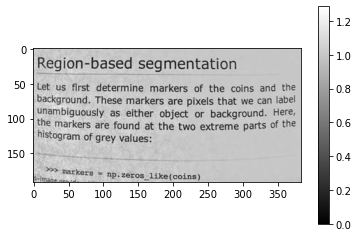

In [46]:
from skimage.filters import rank as skr
from skimage.morphology import disk

g = data.page()
m = skr.median(g,disk(15))
d = g/m
plt.imshow(d,cmap=plt.cm.gray)
plt.colorbar()

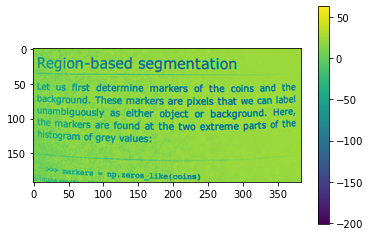

In [47]:
from skimage.filters import rank as skr

m = skr.median(g,disk(12))
p = g-.9*m

plt.imshow(p)
plt.colorbar()

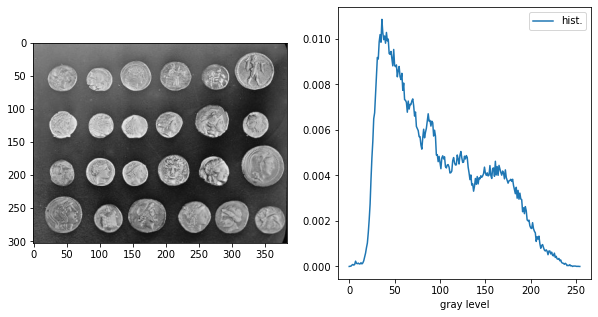

In [10]:
display_hist(data.coins())


uint8


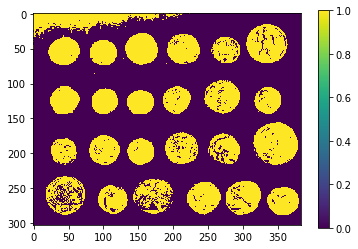

In [11]:
g = data.coins()
t = (g>120).astype(np.uint8)
plt.imshow(t,interpolation='nearest')
plt.colorbar()
print(t.dtype)

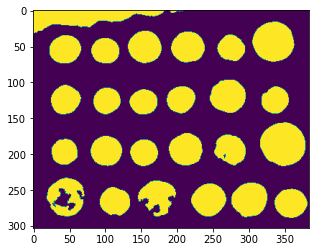

In [12]:
m= skr.median(t,disk(5))
plt.imshow(m)

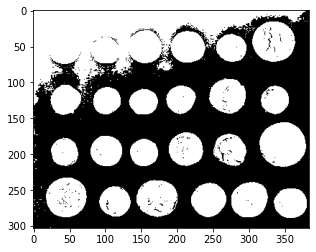

In [13]:
g = data.coins()
t = (g>90).astype(np.uint8)
m = skr.median(t,disk(5))
plt.imshow(t,cmap=plt.cm.gray)

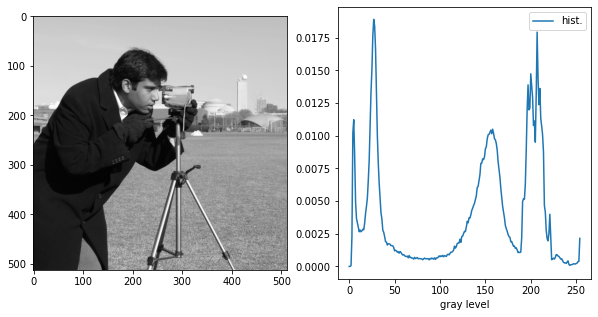

In [14]:
display_hist(data.camera())


array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 1],
       [0, 0, 0, ..., 1, 1, 0]])

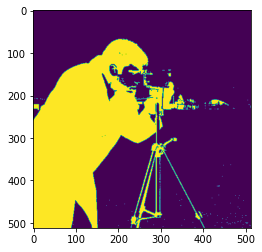

In [15]:
g = data.camera()
t1 = (g>150).astype(int)
t2 = (g>200).astype(int)
t3 = t1+t2
t = g<100
plt.imshow(t)
t3


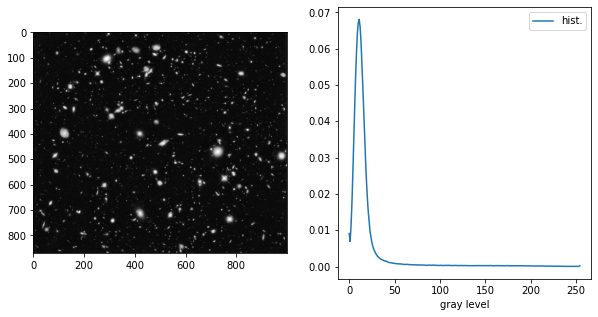

In [16]:
display_hist(data.hubble_deep_field()[:,:,0])

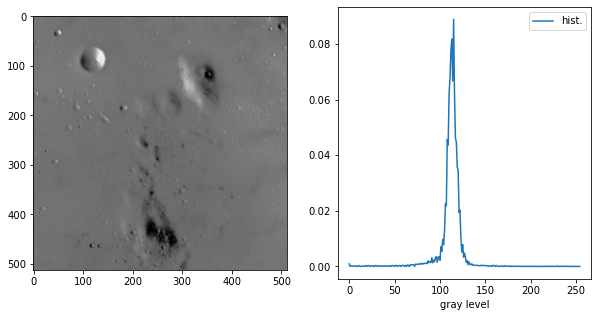

In [17]:
display_hist(data.moon())


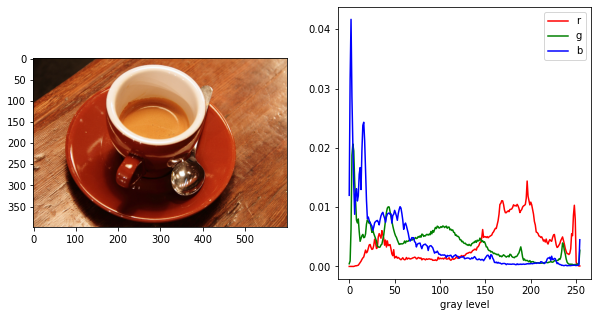

In [18]:
display_hist(data.coffee())


## percentile threshold

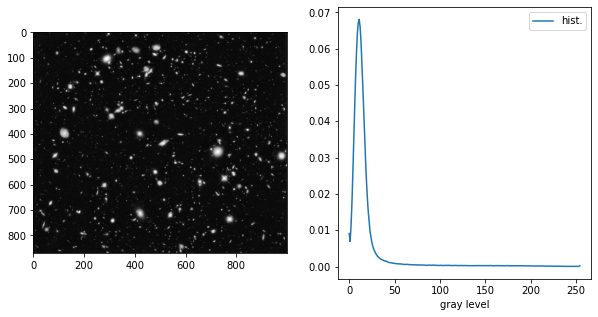

In [54]:
ima = data.hubble_deep_field()[:,:,0]
display_hist(ima)


If we know a priori the surface of the object of interest, here the galaxies, one can set the threshold to the corresponding percentile.

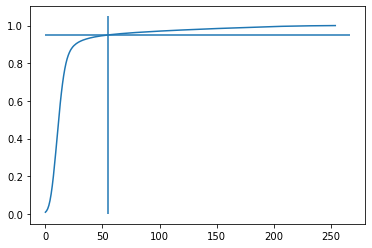

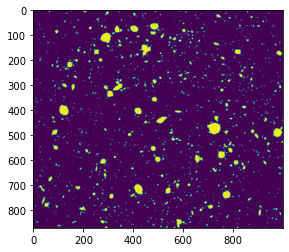

In [55]:
perc = .95 #galaxies are the 5% brighter pixels in the image

h,bins = np.histogram(ima[:],range(256))

c = 1.*np.cumsum(h)/np.sum(h)
plt.plot(c)

plt.gca().hlines(perc,0,plt.gca().get_xlim()[1]);

th_perc = np.where(c>=perc)[0][0]


plt.gca().vlines(th_perc,0,plt.gca().get_ylim()[1]);
plt.figure()
plt.imshow(ima>=th_perc);

## optimal threshold
algorithm:

1. set an initial threshold to $T$
2. cut distribution into:
$$G1 = \{p(x,y)>T\}$$
$$G2 = \{p(x,y)<=T\}$$
3. compute distribution centroid for each part $m1$ and $m2$
4. the new threshold is given by:
$$T’=(m1+m2)/2$$
5. iterate (2) until convergence

Question:
* write a function that finds the optimal threshold for the cameraman
* what clustering method (machine mearning) is equivallent to that algorithm ?

## Otsu's threshold

One define two classes (e.g. foreground/background) based on pixel intensity, classes are separated by a threshold value $k$:

the class probabilities are defined such as:

$$
\begin{align*} 
\omega_0 &=& Pr(C_0) = \sum_{i=0}^k p_i  = \omega (k)\\
\omega_1 &=& Pr(C_1) = \sum_{i=k+1}^L p_i  = 1-\omega (k)\\
\end{align*} 
$$

the class means are defined by:

$$
\begin{align*} 
\mu_0 &=& \sum_{i=0}^k i\:Pr(i|C_0) = \sum_{i=0}^k i\:p_i/\omega_0 = \mu(k)/\omega(k) \\
\mu_1 &=& \sum_{i=k+1}^L i\:Pr(i|C_1) = \sum_{i=k+1}^L i\:p_i/\omega_1 = \frac{\mu_T - \mu(k)}{1-\omega(k)} \\
\end{align*} 
$$

with 

$$
\begin{align*} 
\mu(k) &=& \sum_{i=0}^k i\: p_i\\
\end{align*} 
$$

for the total image one have:

$$
\begin{align*} 
\mu_T &=& \mu(L) = \sum_{i=0}^L i\: p_i  
\end{align*} 
$$

total image values and class values are linked with:

$$
\begin{align*} 
\omega_0 \mu_0 + \omega_1  \mu_1 &=& \mu_T\\
\omega_0 + \omega_1 &=& 1
\end{align*} 
$$

class variances are defined by:

$$
\begin{align*} 
\sigma_0^2 &=& \sum_{i=0}^k (i-\mu_0)^2\:Pr(i|C_0) =\sum_{i=0}^k (i-\mu_0)^2 p_i/\omega_0\\
\sigma_1^2 &=& \sum_{i=k+1}^L (i-\mu_1)^2\:Pr(i|C_1) =\sum_{i=k+1}^L (i-\mu_1)^2 p_i/\omega_1\\
\end{align*} 
$$

variance intra-classe (within):

$$\sigma_W^2 = \omega_0 \sigma_0^2 + \omega_1 \sigma_1^2$$

variance inter-classe (between):
$$
\begin{align*} 
\sigma_B^2 &=& \omega _0 (\mu_0 - \mu_T)^2 + \omega_1(\mu_1-\mu_T)^2\\
&=& \omega_0 \omega_1(\mu_1-\mu_0)^2
\end{align*} 
$$

total variance:
$$\sigma_T^2 = \sum_{i=0}^L (i-\mu_T)^2 p_i$$

separability:
$$\lambda = \sigma_B^2/\sigma_W^2 \:,\: \kappa = \sigma_T^2/\sigma_W^2 \:,\: \eta = \sigma_B^2/\sigma_T^2 $$

Otsu's threshold is $k$ such that separability is maximal (e.g.):

$$\eta = \sigma_B^2(k)/\sigma_T^2(k)$$


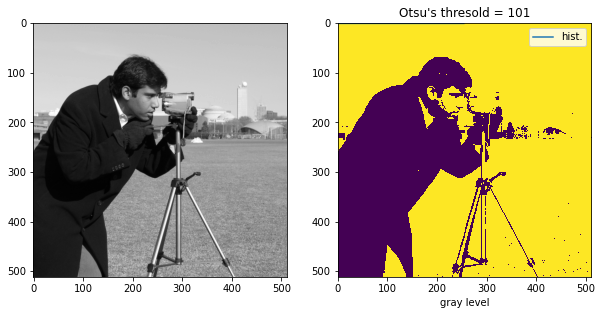

In [21]:
from skimage.filters import threshold_otsu

ima = 255*(1-data.camera())
th = threshold_otsu(ima)
display_hist(ima)
plt.gca().vlines(th,0,plt.gca().get_ylim()[1]);
plt.title("Otsu's thresold = %d"%th );
plt.imshow(ima>th,interpolation='nearest')

>see also:
* Otsu's method [Otsu79](../00-Preface/06-References.ipynb#[Otsu79]) p432

## entropy threshold

The threshold is the value maximizing total entropy, which is the sum of the two subspaces entropies below and above the threshold.

$$ e = - \sum p \, log_2 (p) $$

where $p$ is the probability of occurence for one gray level in one specific subspace.

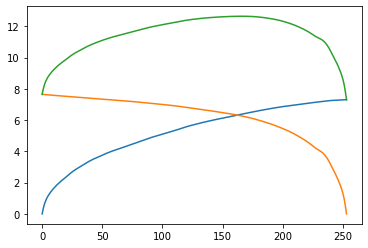

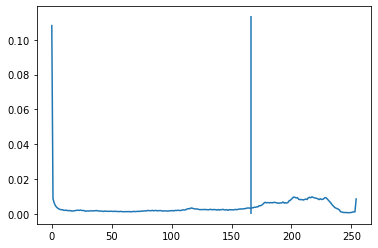

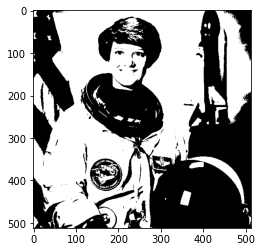

In [22]:
ima = data.astronaut()[:,:,0]

h,_ = np.histogram(ima[:],range(256))
h = h/h.sum() # normalized histogram

def entropy(symb,freq):
    idx = np.asarray(freq) != 0
    s = np.sum(freq)
    p = 1. * freq/s
    e = - np.sum(p[idx] * np.log2(p[idx]))
    return e

e0 = []
e1 = []

for g in range(1,255):
    e0.append(entropy(range(0,g),h[:g]))
    e1.append(entropy(range(g,255),h[g:255]))

e0 = np.asarray(e0)
e1 = np.asarray(e1)

e_max = np.argmax(e0+e1)
plt.plot(e0)
plt.plot(e1)
plt.plot(e0+e1)

plt.figure()
plt.plot(h)
plt.gca().vlines(e_max,0,plt.gca().get_ylim()[1]);
plt.figure()
plt.imshow(ima>e_max,cmap=plt.cm.gray);

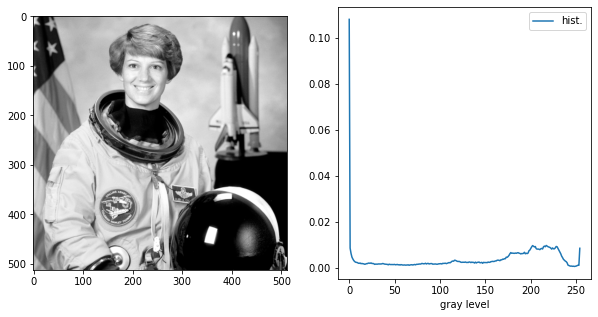

In [23]:
display_hist(ima)

## multi-spectral theshold

For multi-spectral images (e.g. rgb, hsv, etc) one can consider each spectral plane independently and group the obtained segmentations.

The following example apply an Otsu's threshold on each color plane and make a combine the segmented results.

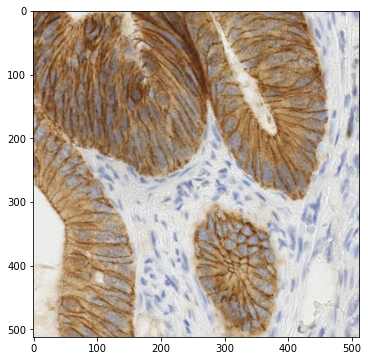

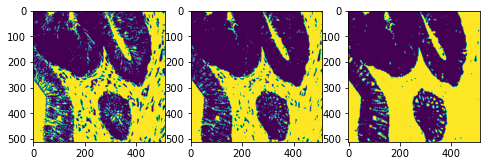

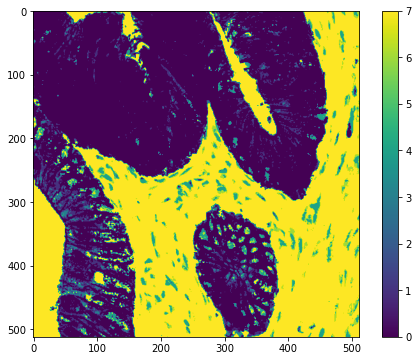

In [24]:
from skimage.filters import threshold_otsu
from skimage.color import rgb2hsv

rgb = data.immunohistochemistry()

r = rgb[:,:,0]
g = rgb[:,:,1]
b = rgb[:,:,2]

th_r = threshold_otsu(r)
th_g = threshold_otsu(g)
th_b = threshold_otsu(b)

mix = (r>th_r).astype(np.uint8) + 2 * (g>th_g).astype(np.uint8) + 4 * (b>th_b).astype(np.uint8)

plt.figure(figsize=[8,6])
plt.imshow(rgb)

plt.figure(figsize=[8,4])
plt.subplot(1,3,1)
plt.imshow(r>th_r)
plt.subplot(1,3,2)
plt.imshow(g>th_g)
plt.subplot(1,3,3)
plt.imshow(b>th_b)

plt.figure(figsize=[8,6])
plt.imshow(mix)
plt.colorbar();



Questions:
* what appens in an other color space ?
* can we use this approach for images that are not multi-spectral ?

## adding spectral dimensions

Sometime the gray level information is not enough to segment the image, the folowing image presents clearly 3 regions of different average gray level.

Howerver, we also distinguish a variable texture in the central part of the image, the texture is more coarse than on the lateral borders.


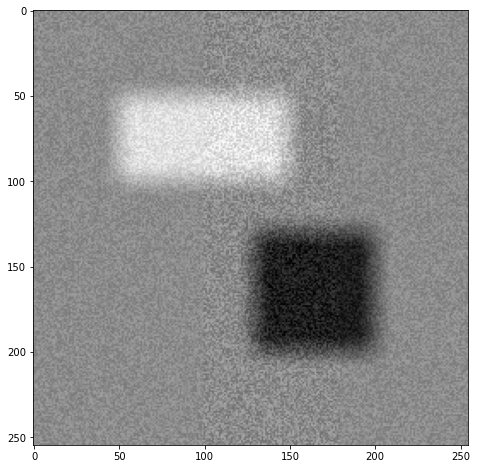

In [25]:
import skimage.filters.rank as skr
from skimage.morphology import disk

ima = (128*np.ones((255,255))).astype(np.uint8)
ima[50:100,50:150] = 150
ima[130:200,130:200] = 100

ima = skr.mean(ima,disk(10))

mask = 10.*np.ones_like(ima)
mask[:,100:180] = 15
# add variable noise

n = np.random.random(ima.shape)-.5
ima = (ima + mask*n).astype(np.uint8)


entropy = 255.*skr.entropy(ima,disk(4))/8

plt.figure(figsize=[8,8])
plt.imshow(ima,cmap=plt.cm.gray);

the gray level histogram exhibits three peaks corresponding to the three gray levels present in the image.

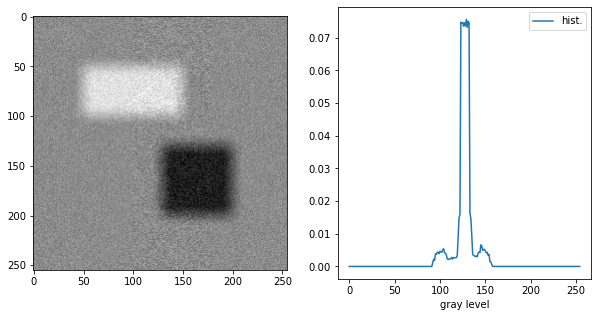

In [26]:
display_hist(ima)

in order to detect the variation of noise inside the central part, one can use a local entropy measurement, we now observe a clear contrast between the central band and the image left and right borders. Entropy is also sensitive to sharp gray level variation, so the box borders are also emphasized.

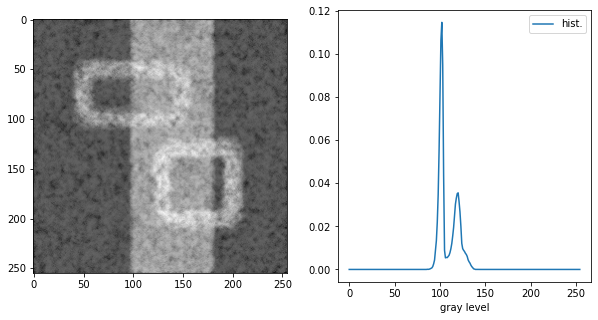

In [27]:

display_hist(entropy)

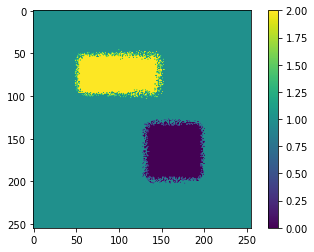

In [28]:
r = np.zeros_like(ima)
r[ima>110] = 1
r[ima>140] = r[ima>140]+1

plt.imshow(r)
plt.colorbar();

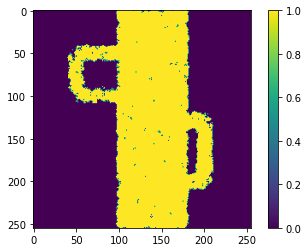

In [29]:
s = np.zeros_like(entropy)
s[entropy>110] = 1
s[entropy>140] = 0
plt.imshow(s)
plt.colorbar();

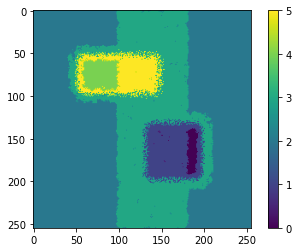

In [30]:
plt.imshow(s+2*r)
plt.colorbar()